# CRiCD4 Full dataset - QC analysis

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import os
import yaml
import scanpy as sc
import anndata as ad
import rapids_singlecell as rsc
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15

from preprocess import _convert_oak_path
import qc_plots
from sgrna_assignment import sgrna_assignments2adata

In [38]:
import psutil

# Get system memory information
mem_info = psutil.virtual_memory()

# Display total, available, and used memory in GB
print(f"Total memory: {mem_info.total / (1024**3):.2f} GB")
print(f"Available memory: {mem_info.available / (1024**3):.2f} GB")
print(f"Used memory: {mem_info.used / (1024**3):.2f} GB")
print(f"Memory percentage used: {mem_info.percent}%")

Total memory: 995.52 GB
Available memory: 407.32 GB
Used memory: 571.52 GB
Memory percentage used: 59.1%


In [39]:
PLOTDIR = f'../../results/CD4i_final/'
sc.settings.figdir = PLOTDIR
os.makedirs(PLOTDIR, exist_ok=True)

def save_plot(pl_name, plot_dir = None):
    if plot_dir is None:
        plot_dir = PLOTDIR
    plt.savefig(f'{plot_dir}/{pl_name}.pdf');
    plt.savefig(f'{plot_dir}/{pl_name}.png');

Configuration

In [40]:
# Read config
config_file = '../../metadata/experiments_config.yaml'
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)

## Summary of QC metrics

In [42]:
experiment_list = ['CD4iR2_Psomagen', 'CD4iR1_Psomagen']
all_qc_summary_list = []
all_count_perturbs_list = []

for experiment_name in experiment_list:
    exp_config = config[experiment_name]
    datadir = _convert_oak_path(exp_config['datadir'])
    qc_summary = pd.read_csv(f'{datadir}/QC_summary_stats.csv', index_col=0)
    count_perturbs = pd.read_csv(f'{datadir}/perturbation_counts.csv', index_col=0)
    qc_summary['experiment'] = experiment_name
    count_perturbs['experiment'] = experiment_name
    all_qc_summary_list.append(qc_summary)
    all_count_perturbs_list.append(count_perturbs)

all_qc_summary = pd.concat(all_qc_summary_list, axis=0)
all_count_perturbs = pd.concat(all_count_perturbs_list, axis=0)

In [43]:
all_qc_summary.value_counts('library_id')

library_id
CD4i_R2_D1_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D2_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D3_Rest_CD4i_R2_Ultima        24
CD4i_R2_D3_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D3_Stim8hr_CD4i_R2_Ultima     24
CD4i_R2_D4_Rest_CD4i_R2_Ultima        24
CD4i_R2_D4_Stim48hr_CD4i_R2_Ultima    24
CD4i_R2_D4_Stim8hr_CD4i_R2_Ultima     24
CD4i_R1_D1_Rest_CD4i_R1_Ultima        23
CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima     23
CD4i_R1_D2_Rest_CD4i_R1_Ultima        23
CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima     23
Name: count, dtype: int64

In [44]:
all_qc_summary.head()

,library_id,lane_id,mean_total_counts,mean_n_genes,mean_pct_counts_mt,mean_top_guide_UMI_counts,n_cells,n_low_quality_cells,NTC single sgRNA,multi sgRNA,no sgRNA (>= 3 UMIs),targeting single sgRNA,n_unique_guides,n_unique_perturbed_genes,mean_cells_x_guide,mean_cells_x_perturbed_gene,experiment
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L01,13285.634,4187.814500,0.573849,150.328896,113914,443,3219,23860,11295,75097,14076,9634,5.563797,8.129126,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L02,16580.342,4556.615607,0.599576,141.191995,88433,409,2446,17097,10388,58093,12508,8882,4.840022,6.815920,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L03,13797.838,4212.409915,0.592349,143.489722,89504,397,2457,16912,10338,59400,12608,8951,4.906171,6.910625,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L04,15891.131,4525.213117,0.584216,146.301763,88740,452,2381,17277,10218,58412,12691,8984,4.790245,6.766808,CD4iR2_Psomagen
0,CD4i_R2_D3_Rest_CD4i_R2_Ultima,CD4i_R2L05,15209.561,4435.575832,0.579576,150.594691,107521,490,3000,23255,10664,70112,13801,9511,5.297587,7.687099,CD4iR2_Psomagen


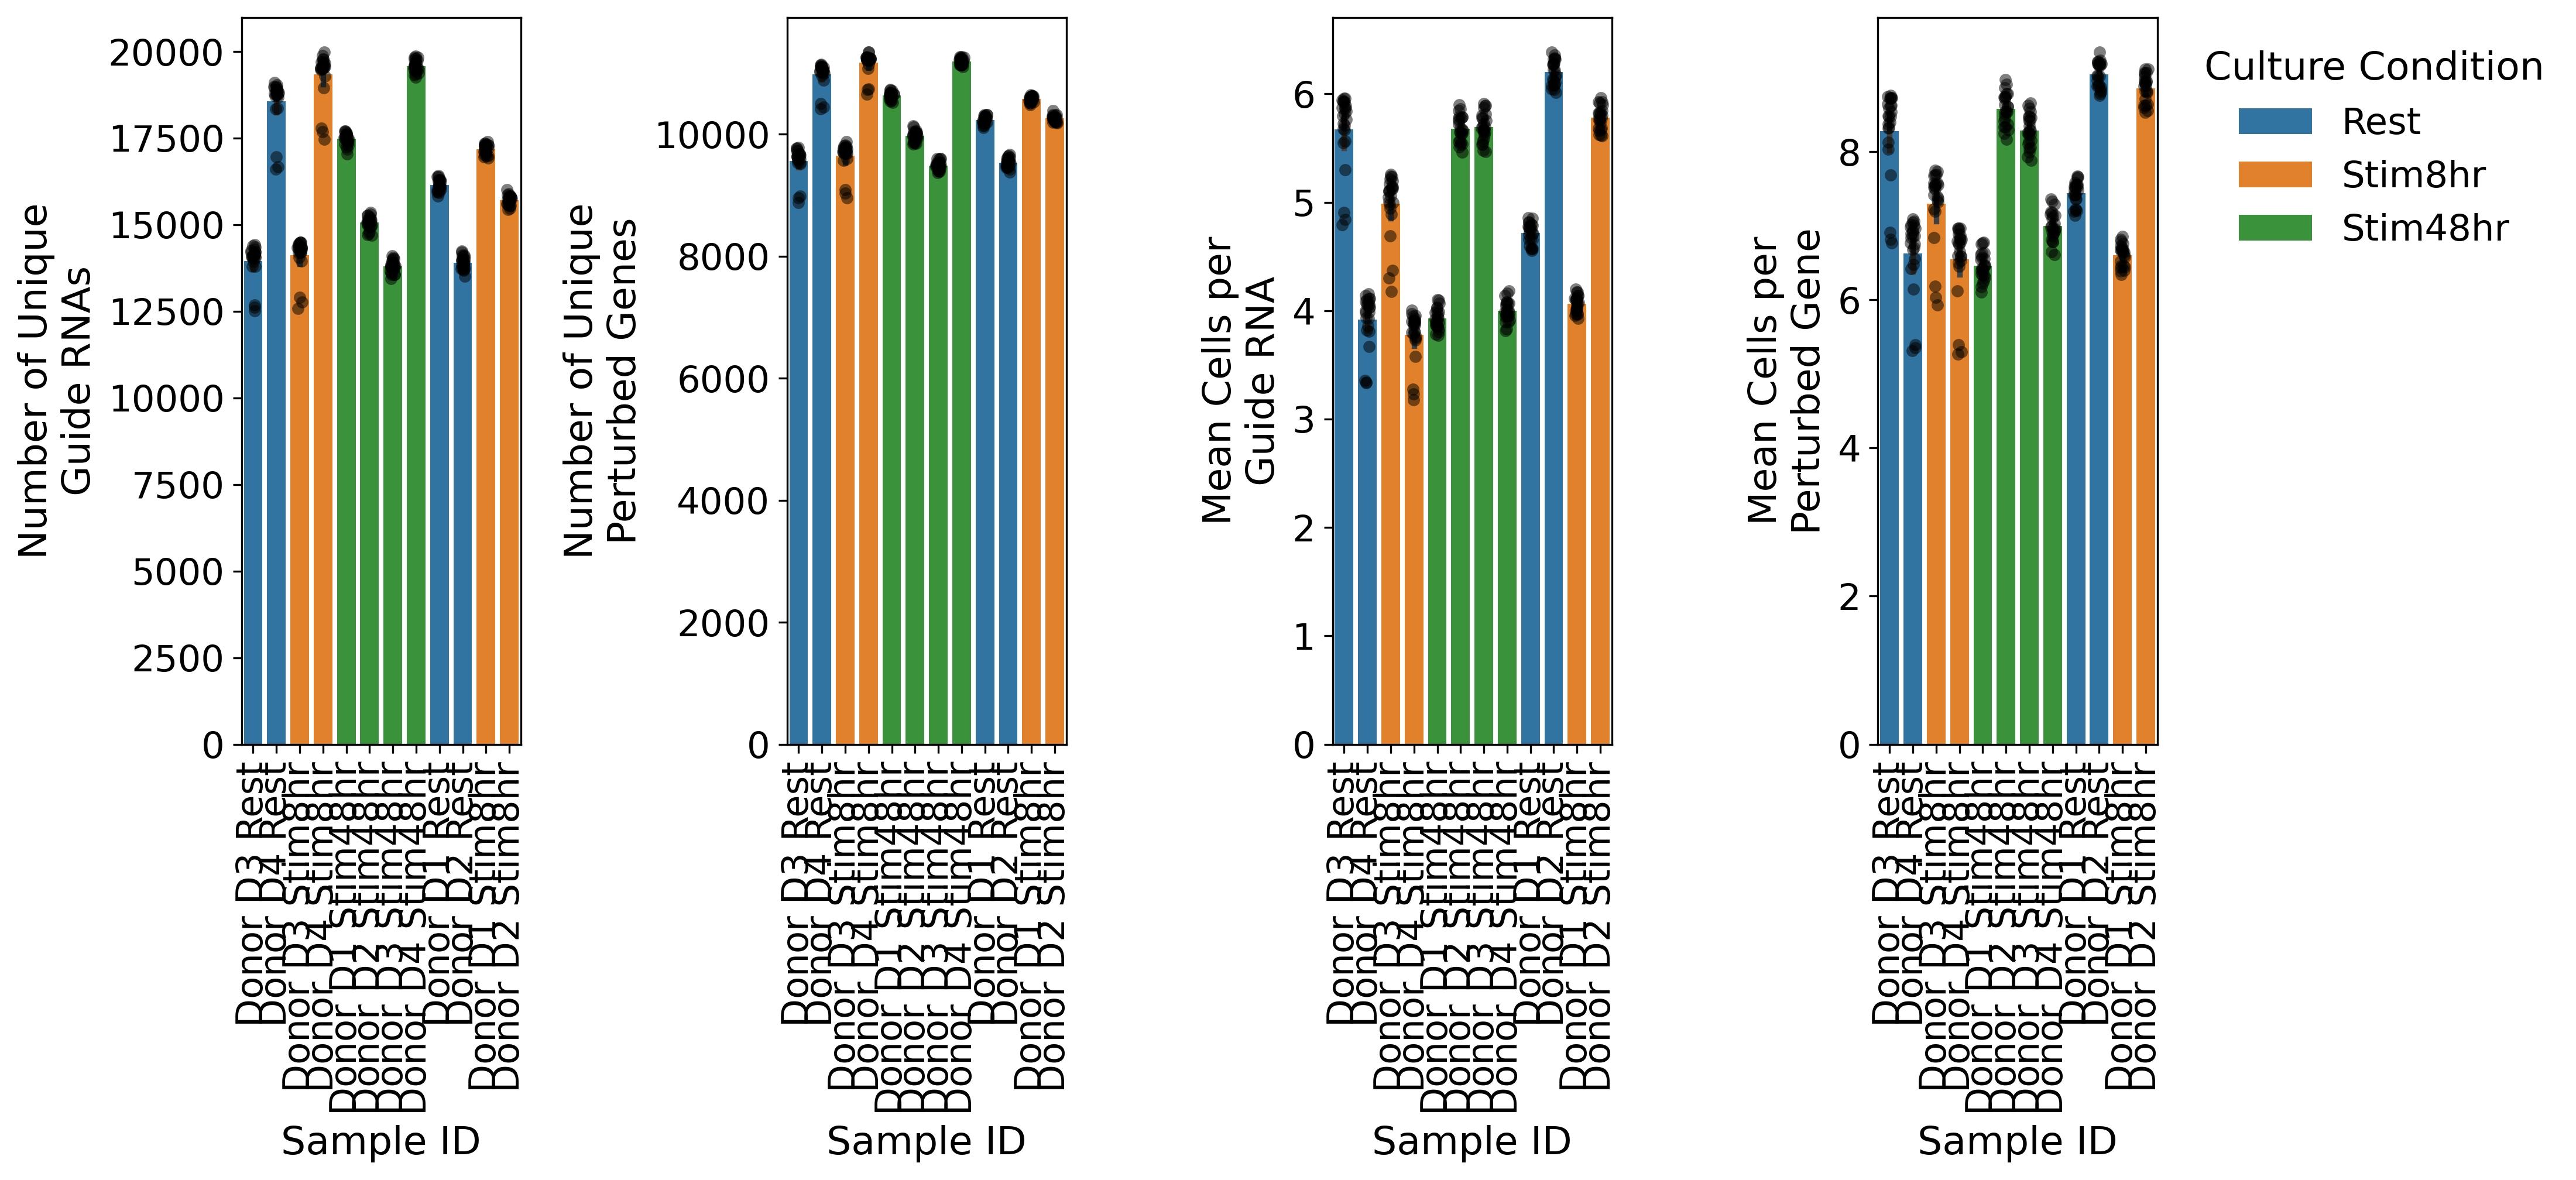

In [45]:
pl_cols = ['n_unique_guides',
       'n_unique_perturbed_genes', 'mean_cells_x_guide',
       'mean_cells_x_perturbed_gene'
       ]

# Define better y-axis labels
y_labels = {
    'n_unique_guides': 'Number of Unique\nGuide RNAs',
    'n_unique_perturbed_genes': 'Number of Unique\nPerturbed Genes',
    'mean_cells_x_guide': 'Mean Cells per\nGuide RNA',
    'mean_cells_x_perturbed_gene': 'Mean Cells per\nPerturbed Gene'
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(15, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, 
                 legend=False, ax=axes[idx])
    
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()

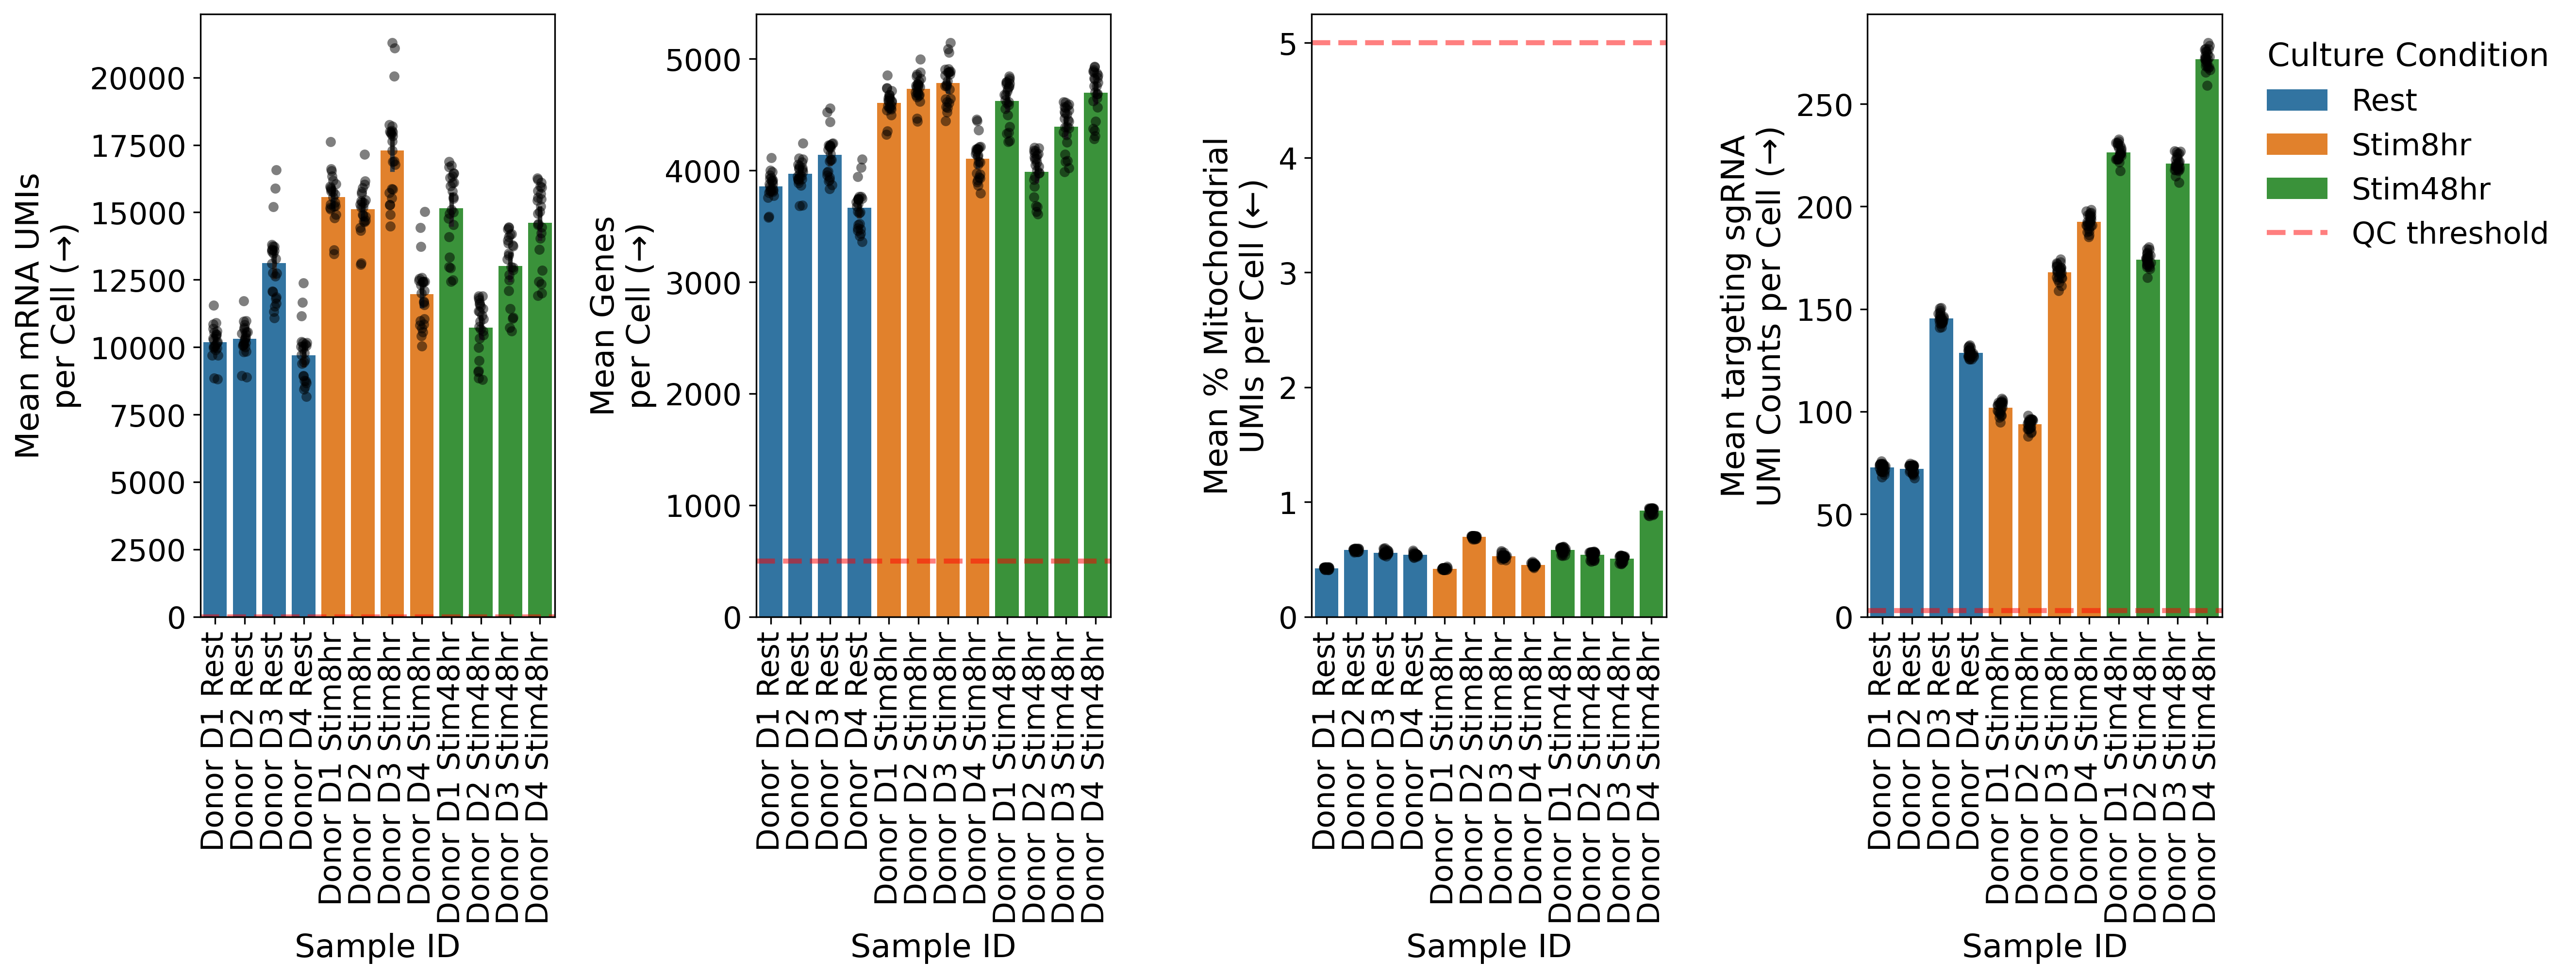

In [69]:
pl_cols = ['mean_total_counts', 'mean_n_genes',
       'mean_pct_counts_mt', 'mean_top_guide_UMI_counts'
       ]

qc_thresholds = {
    'mean_total_counts':0,
    'mean_n_genes':500,
    'mean_pct_counts_mt':5,
    'mean_top_guide_UMI_counts':3   
}

# Define better y-axis labels
y_labels = {
    'mean_total_counts': 'Mean mRNA UMIs\nper Cell (→)',  # Higher is better
    'mean_n_genes': 'Mean Genes\nper Cell (→)',  # Higher is better
    'mean_pct_counts_mt': 'Mean % Mitochondrial\nUMIs per Cell (←)',  # Lower is better
    'mean_top_guide_UMI_counts': 'Mean targeting sgRNA\nUMI Counts per Cell (→)'  # Higher is better
}

all_qc_summary['donor_id'] = all_qc_summary['library_id'].str.split('_').str[2]
all_qc_summary['culture_condition'] = all_qc_summary['library_id'].str.split('_').str[3]
all_qc_summary['sample_id'] = 'Donor ' + all_qc_summary['donor_id'] + ' ' + all_qc_summary['culture_condition']

# Create ordered list of sample_ids
sample_id_order = []
for condition in ['Rest', 'Stim8hr', 'Stim48hr']:
    for donor in sorted(all_qc_summary['donor_id'].unique()):
        sample_id = f'Donor {donor} {condition}'
        if sample_id in all_qc_summary['sample_id'].values:
            sample_id_order.append(sample_id)

# Create subplots for each metric in one row
n_cols = len(pl_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(18, 7))

for idx, col in enumerate(pl_cols):
    sns.barplot(data=all_qc_summary, x='sample_id', y=col, hue='culture_condition', 
                order=sample_id_order, ax=axes[idx])
    sns.stripplot(data=all_qc_summary, x='sample_id', y=col, color='black', 
                 size=5, alpha=0.5, order=sample_id_order,
                 legend=False, ax=axes[idx])
    
    # Add horizontal dotted line for QC threshold
    threshold = qc_thresholds[col]
    axes[idx].axhline(y=threshold, color='red', linestyle='--', alpha=0.5, 
                     label=f'QC threshold', linewidth=2.5)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90)
    axes[idx].set_xlabel('Sample ID')
    axes[idx].set_ylabel(y_labels[col])
    
    # Only show legend on first plot
    if idx != 3:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='Culture Condition', frameon=False)

plt.tight_layout()
plt.savefig(PLOTDIR + "QC_metrics.png")
plt.savefig(PLOTDIR + "QC_metrics.pdf")

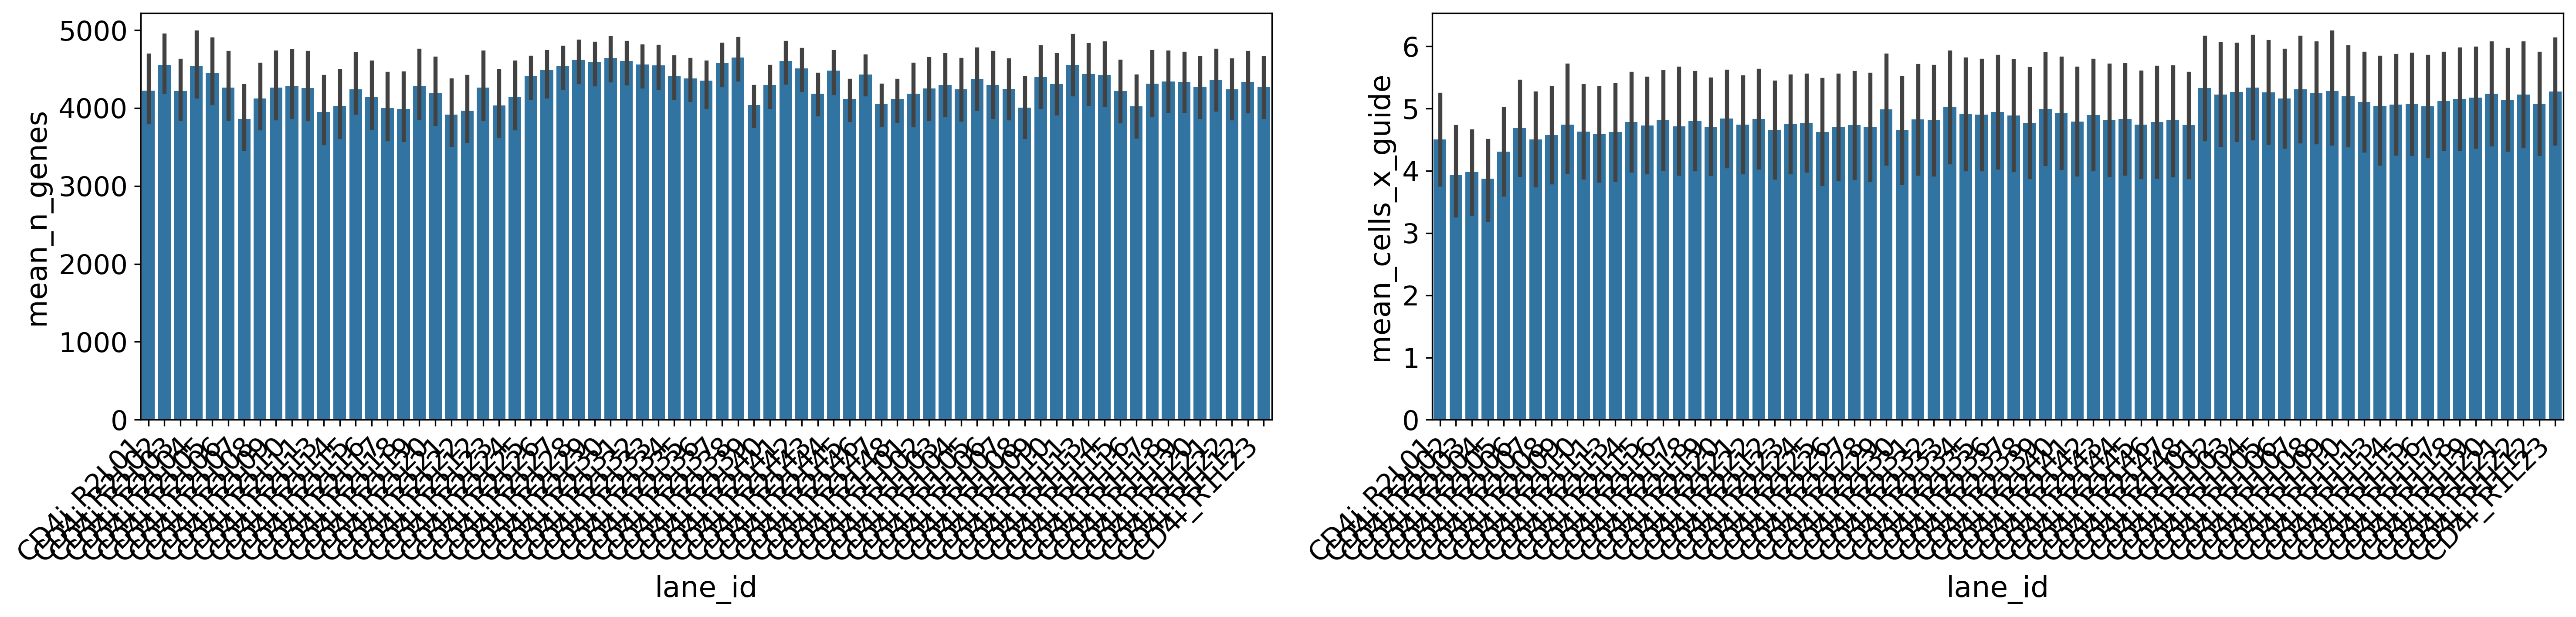

In [70]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))

sns.barplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_n_genes', ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

sns.barplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
# sns.stripplot(all_qc_summary, x='lane_id', y='mean_cells_x_guide', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

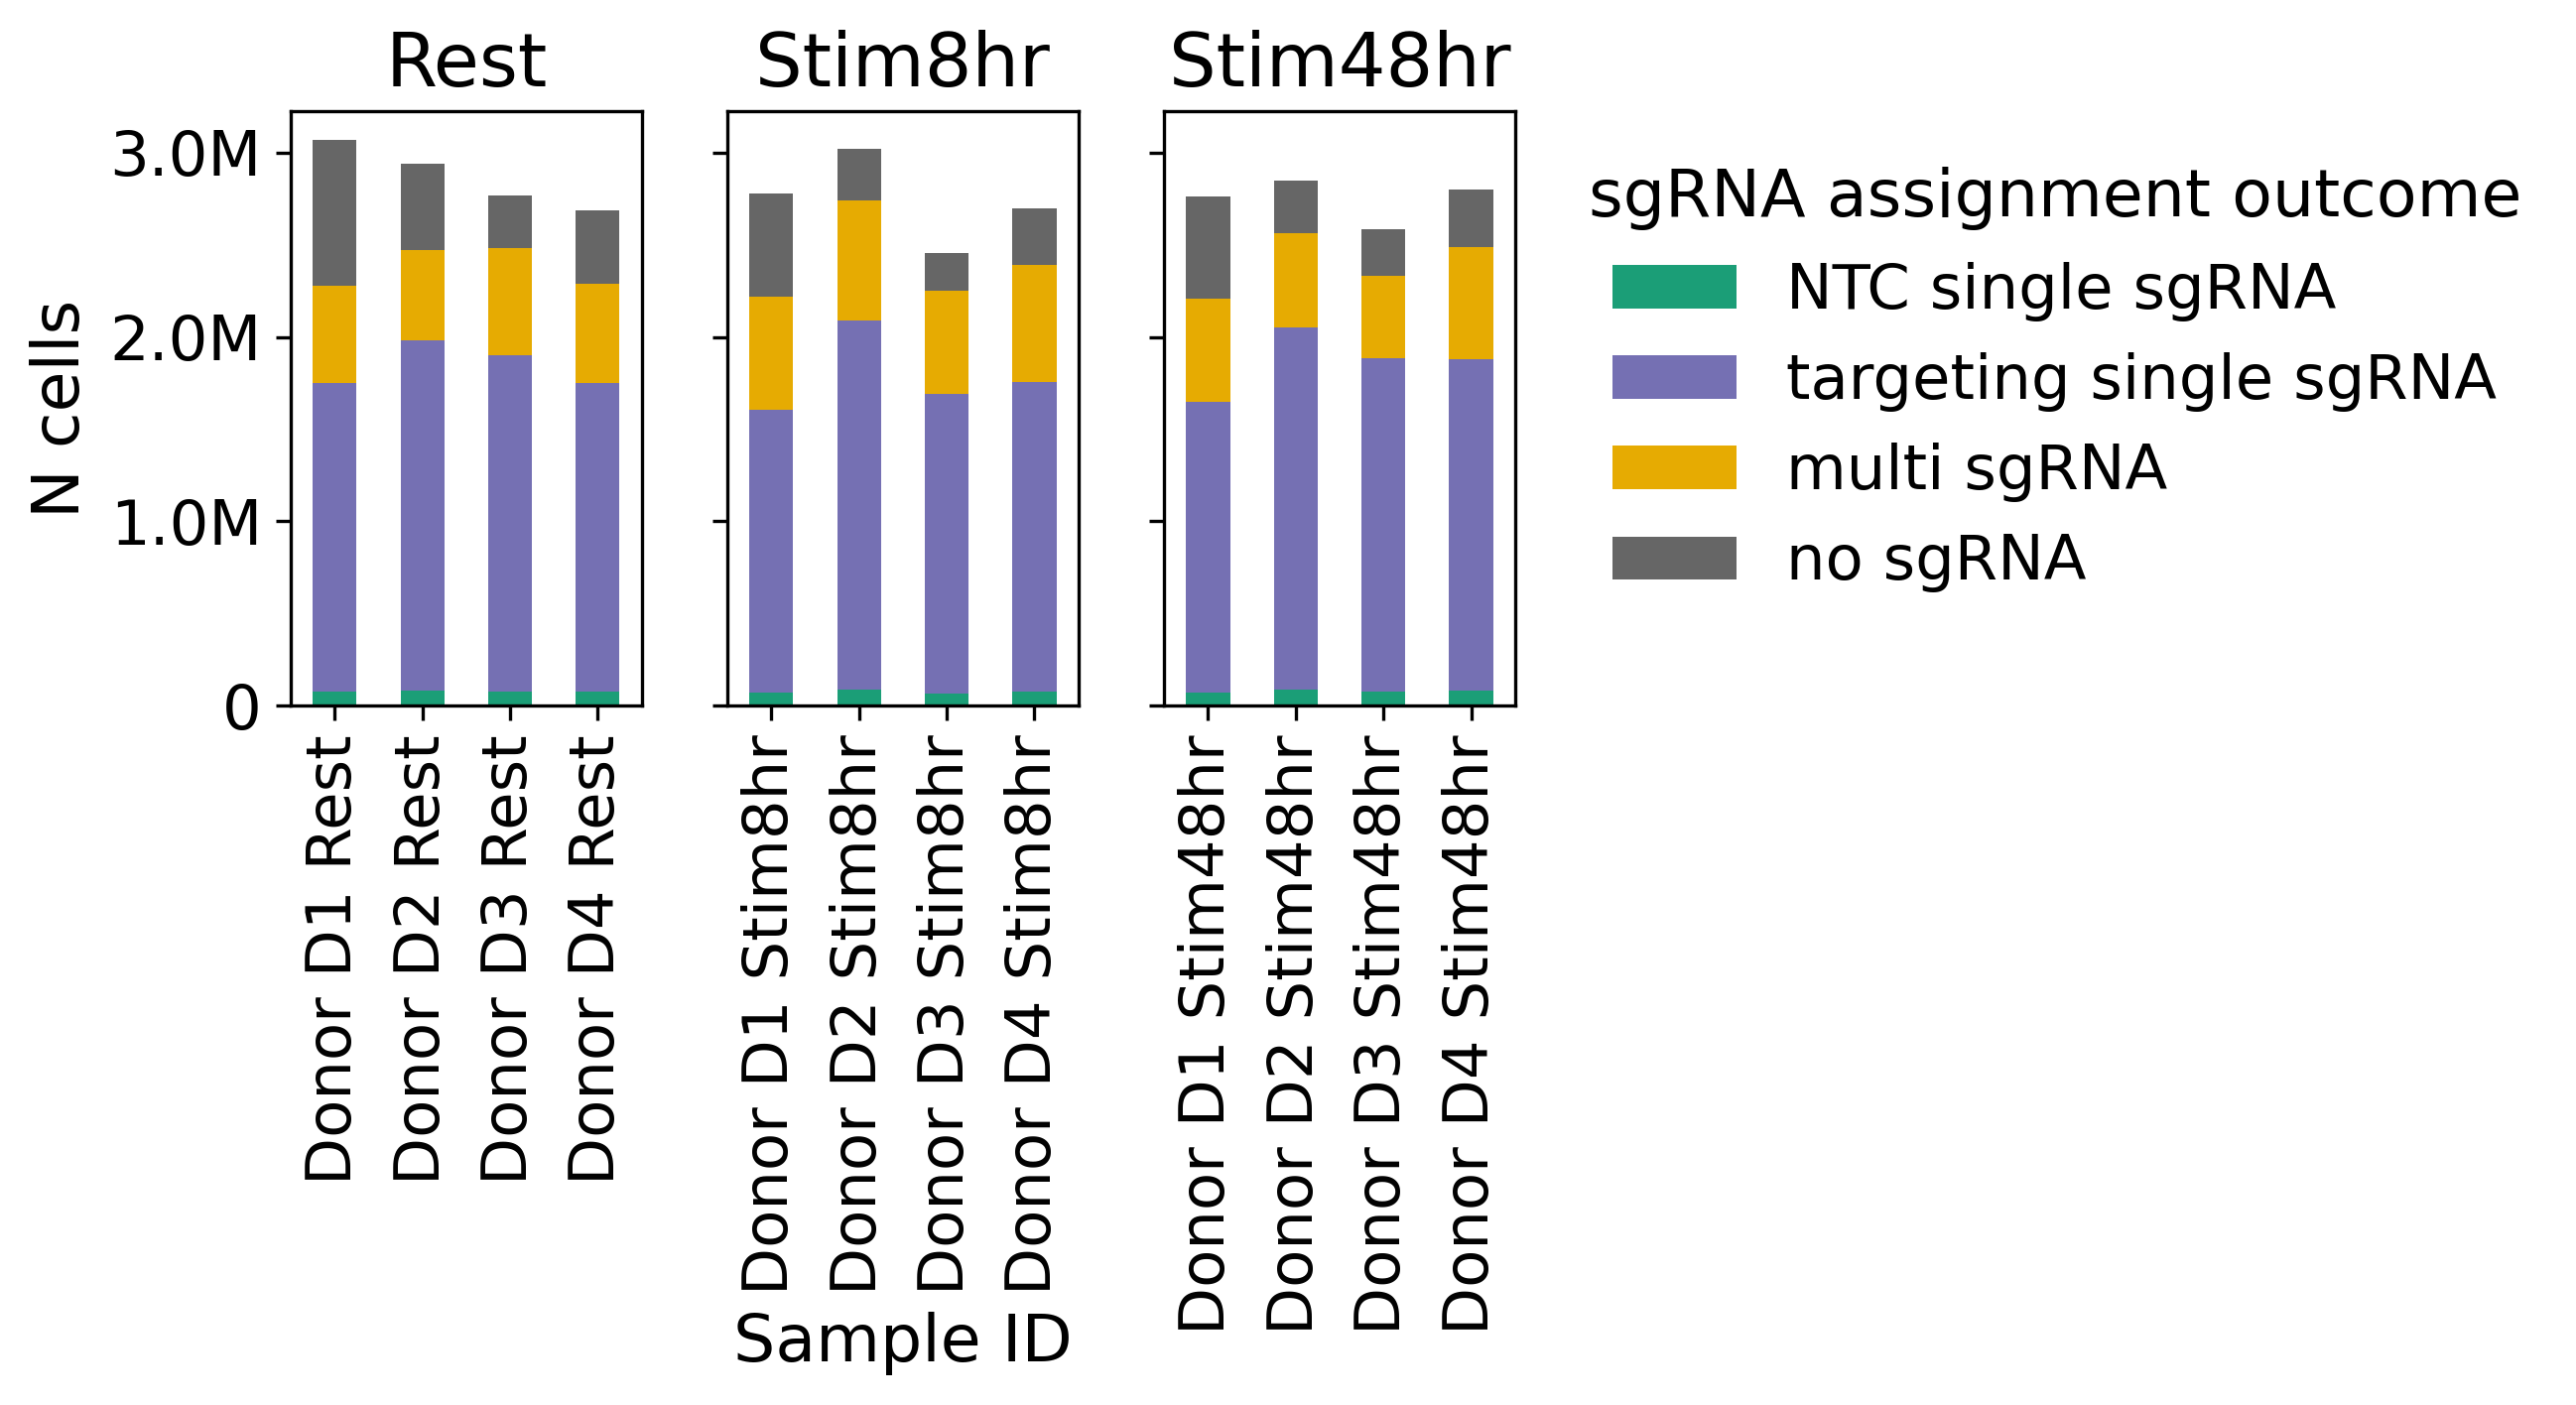

In [78]:
pl_df = all_qc_summary.groupby('sample_id').sum()
# Define the order for the groups
group_order = ['NTC single sgRNA', 'targeting single sgRNA', 'multi sgRNA', 'no sgRNA (>= 3 UMIs)']

# Create subplots for each culture condition
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
fig, axes = plt.subplots(1, len(conditions), figsize=(9, 5), sharey=True)

for idx, condition in enumerate(conditions):
    # Filter data for this condition
    condition_samples = [col for col in pl_df.index if condition in col]
    condition_data = pl_df.loc[condition_samples][group_order]
    condition_data = condition_data.rename({'no sgRNA (>= 3 UMIs)':'no sgRNA'}, axis=1)
    
    # Create stacked bar plot
    condition_data.plot(kind='bar', stacked=True, ax=axes[idx], colormap='Dark2')
    axes[idx].set_title(condition)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, ha='center')
    axes[idx].set_ylabel('N cells' if idx == 0 else '')
    if idx == 1:
        axes[idx].set_xlabel('Sample ID')
    else:
        axes[idx].set_xlabel('')
    
    # Format y-axis to use M notation for millions
    axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M' if x >= 1e6 else f'{int(x/1e3)}K' if x >= 1e3 else int(x)))
    
    # Only show legend for last subplot
    if idx != len(conditions)-1:
        axes[idx].get_legend().remove()
    else:
        axes[idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
                        title='sgRNA assignment outcome', frameon=False)

plt.tight_layout()
plt.savefig(PLOTDIR + "N_cells_assignment.png")
plt.savefig(PLOTDIR + "N_cells_assignment.pdf")

### Number of cells per perturbation

In [79]:
# Download and read the Core Essential and non-essential gene list (as used in GeneBayes paper)
ceg_url = "https://raw.githubusercontent.com/macarthur-lab/gene_lists/master/lists/CEGv2_subset_universe.tsv"
neg_url = 'https://raw.githubusercontent.com/macarthur-lab/gene_lists/refs/heads/master/lists/NEGv1_subset_universe.tsv'
core_essential = pd.read_csv(ceg_url, sep='\t', header=None)[0].tolist()
core_nonessential = pd.read_csv(neg_url, sep='\t', header=None)[0].tolist()

## Load IL2 hits
schmidt_crispri = pd.read_excel('../../metadata/Schmidt2022_hits_Supplementary_table_2.xlsx', usecols=range(10))
schmidt_crispri_hits = schmidt_crispri[schmidt_crispri['Hit'] & (schmidt_crispri['CRISPRa_or_i'] == 'CRISPRi') & (schmidt_crispri['CD4_or_CD8'] == 'CD4')]

# Create dictionary where key is hit type and values are lists of genes
hit_type_dict = {}
for hit_type in schmidt_crispri_hits['Hit_Type'].unique():
    hit_type_dict[hit_type] = schmidt_crispri_hits[schmidt_crispri_hits['Hit_Type'] == hit_type]['Gene'].tolist()


In [80]:
pl_df = all_count_perturbs.reset_index().melt(id_vars='guide_id', var_name='library_id', value_name='n_cells')
pl_df = pd.merge(
    sgrna_library_metadata[['sgrna_id', 'perturbed_gene_name']].rename({'sgrna_id':'guide_id'}, axis=1),
    pl_df
)
pl_df['sample_id'] = pl_df.library_id.str.split('.').str[0]
pl_df['culture_condition'] = pl_df['sample_id'].str.split('_').str[3]

n_cells_count_df = pl_df.groupby(['perturbed_gene_name','culture_condition'])['n_cells'].sum().reset_index()


In [81]:
n_cells_count_df.groupby('culture_condition')['n_cells'].mean()

culture_condition
Rest        580.045155
Stim48hr    586.361552
Stim8hr     561.003534
Name: n_cells, dtype: object

In [82]:
n_cells_count_df['Schmidt_hits'] = np.nan
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Positive Hit']), 'IL2_pos_hit', n_cells_count_df['Schmidt_hits'])
n_cells_count_df['Schmidt_hits'] = np.where(n_cells_count_df.perturbed_gene_name.isin(hit_type_dict['Negative Hit']), 'IL2_neg_hit', n_cells_count_df['Schmidt_hits'])

n_cells_count_df['essential_genes'] = np.nan
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_essential), 'gold standard essential', n_cells_count_df['essential_genes'])
n_cells_count_df['essential_genes'] = np.where(n_cells_count_df.perturbed_gene_name.isin(core_nonessential), 'gold standard non-essential', n_cells_count_df['essential_genes'])


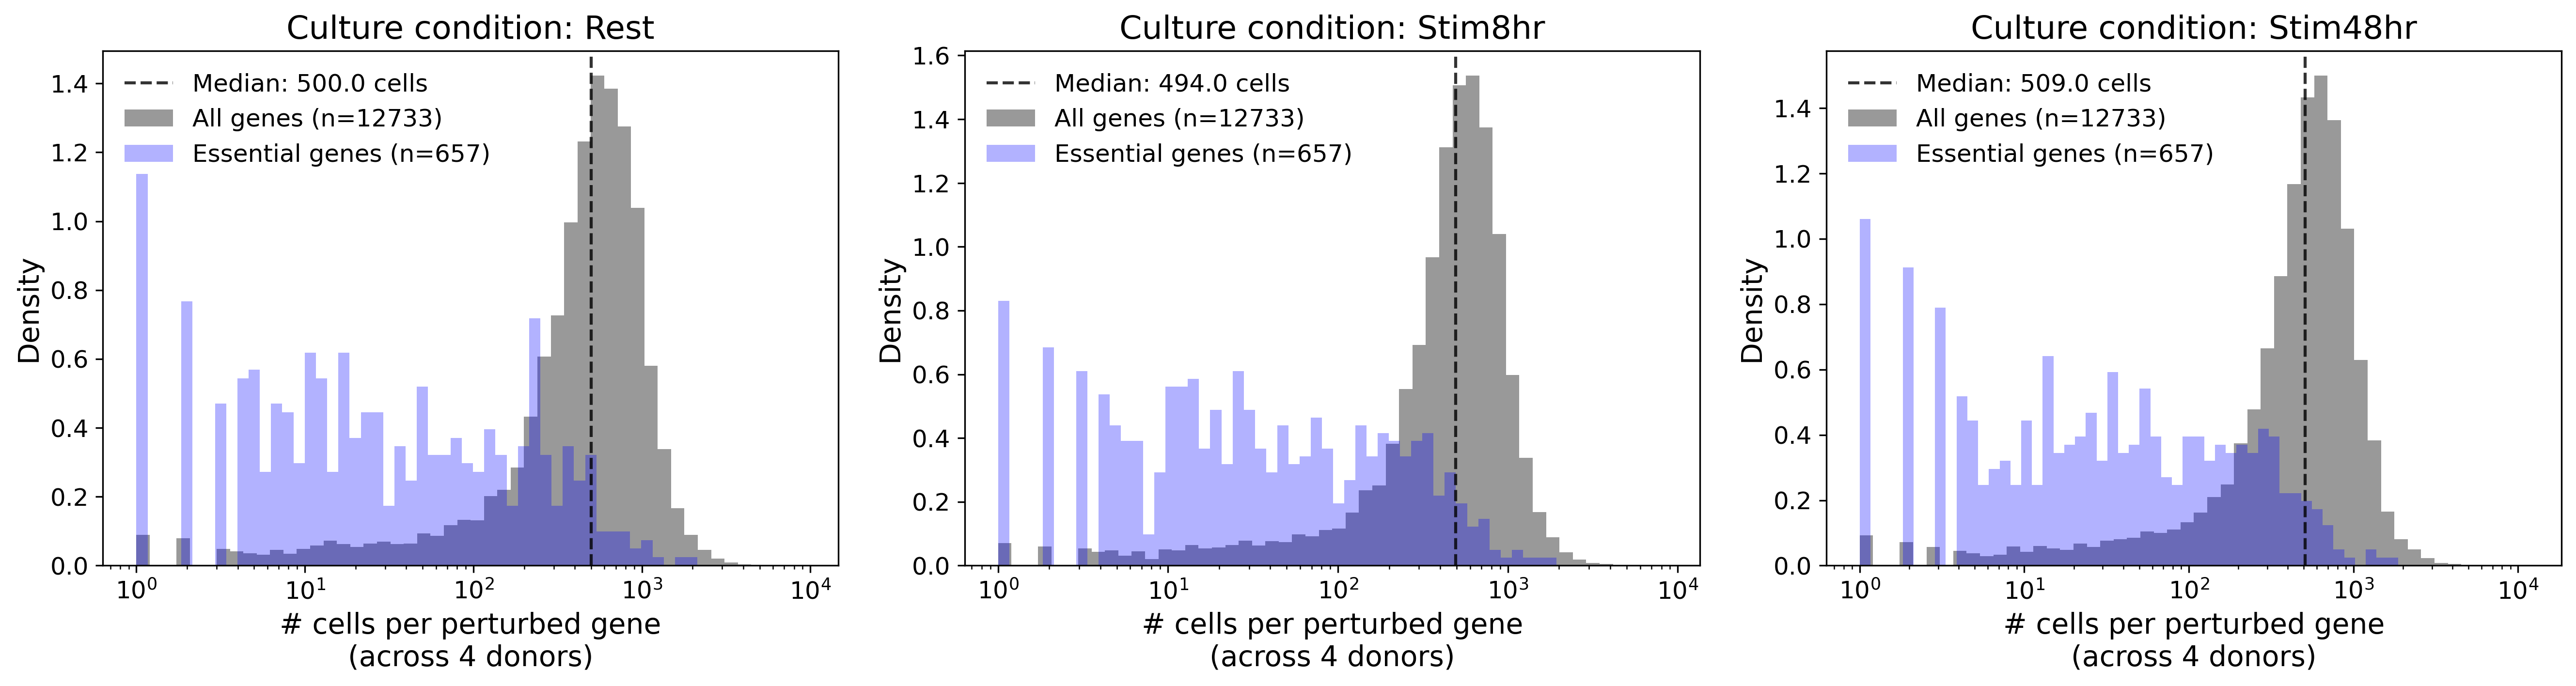

In [87]:
# Create histogram with density lines comparing IL2_neg_hit genes and essential genes with all genes
essential_df = n_cells_count_df[n_cells_count_df['essential_genes'] == 'gold standard essential']
all_genes_df = n_cells_count_df[n_cells_count_df.perturbed_gene_name != 'NTC']  # All genes except NTC

# Get unique conditions
conditions = ['Rest', 'Stim8hr', 'Stim48hr']
n_conditions = len(conditions)

# Create figure with subplots - one per condition
fig, axes = plt.subplots(1, n_conditions, figsize=(6*n_conditions, 5))

# Plot for each condition
for i, condition in enumerate(conditions):
    condition_all = all_genes_df[all_genes_df['culture_condition'] == condition]
    condition_essential = essential_df[essential_df['culture_condition'] == condition]

    # Get unique gene counts for legend
    n_all = len(condition_all['perturbed_gene_name'].unique())
    n_essential = len(condition_essential['perturbed_gene_name'].unique())

    # Plot histogram for all genes
    sns.histplot(data=condition_all, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color='gray', alpha=0.8, label=f'All genes (n={n_all})', kde=True, ax=axes[i],
                edgecolor='none')

    # Add vertical line for median
    axes[i].axvline(x=condition_all['n_cells'].median(), color='black', alpha=0.8, linestyle='--',
                    label=f'Median: {condition_all["n_cells"].median():.1f} cells')

    # Plot histogram for essential genes
    sns.histplot(data=condition_essential, x='n_cells', bins=50,
                stat='density', common_norm=False, log_scale=True,
                color='blue', alpha=0.3, ax=axes[i], label=f'Essential genes (n={n_essential})',
                edgecolor='none')

    # Customize plot
    axes[i].set_title(f'Culture condition: {condition}', fontsize=16)
    axes[i].legend(fontsize=12, frameon=False)
    axes[i].set_xlabel('# cells per perturbed gene\n(across 4 donors)', fontsize=14)
    axes[i].set_ylabel('Density', fontsize=14)
    axes[i].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.savefig(PLOTDIR + "N_cells_perturb.png")
plt.savefig(PLOTDIR + "N_cells_perturb.pdf")

Check tail of distribution that are not in IL2 regulators or essential genes

In [88]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Rest') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['AP2M1',
 'ATP6AP1',
 'ATRIP',
 'BTF3',
 'C12orf60',
 'CDAN1',
 'CDCA5',
 'CENPH',
 'CWC15',
 'CWC22',
 'EIF2B2',
 'GBF1',
 'GLE1',
 'HAUS6',
 'ISY1-RAB43',
 'LSM4',
 'LSM6',
 'MAT2A',
 'MZT1',
 'NCSTN',
 'NUP205',
 'PHAX',
 'PMF1',
 'RFC3',
 'RPS3A',
 'SCFD1',
 'SENP6',
 'SF3B4',
 'SNRPE',
 'SUPT16H',
 'TAF1A',
 'TBCE',
 'THAP1',
 'TIMELESS',
 'TOX4',
 'TREX2',
 'UBAP1',
 'ZNF511']

In [90]:
n_cells_count_df[
    (n_cells_count_df.culture_condition == 'Stim48hr') & 
    (n_cells_count_df['n_cells'] == 0) &
    (n_cells_count_df['Schmidt_hits'] == 'nan') &
    (n_cells_count_df['essential_genes'] == 'nan')
]['perturbed_gene_name'].tolist()

['ATP6V1C1',
 'BNIP1',
 'BRF1',
 'C5orf22',
 'DDX46',
 'EIF2B2',
 'GBF1',
 'GFPT1',
 'HSPA5',
 'KANSL2',
 'MAT2A',
 'MZT1',
 'NBPF12',
 'NCAPG',
 'PDCD11',
 'POLD2',
 'RPL7',
 'RPS9',
 'RRP7A',
 'SF3B4',
 'SF3B6',
 'SNRPE',
 'THAP1',
 'VPS51',
 'ZMAT2',
 'ZNF511']

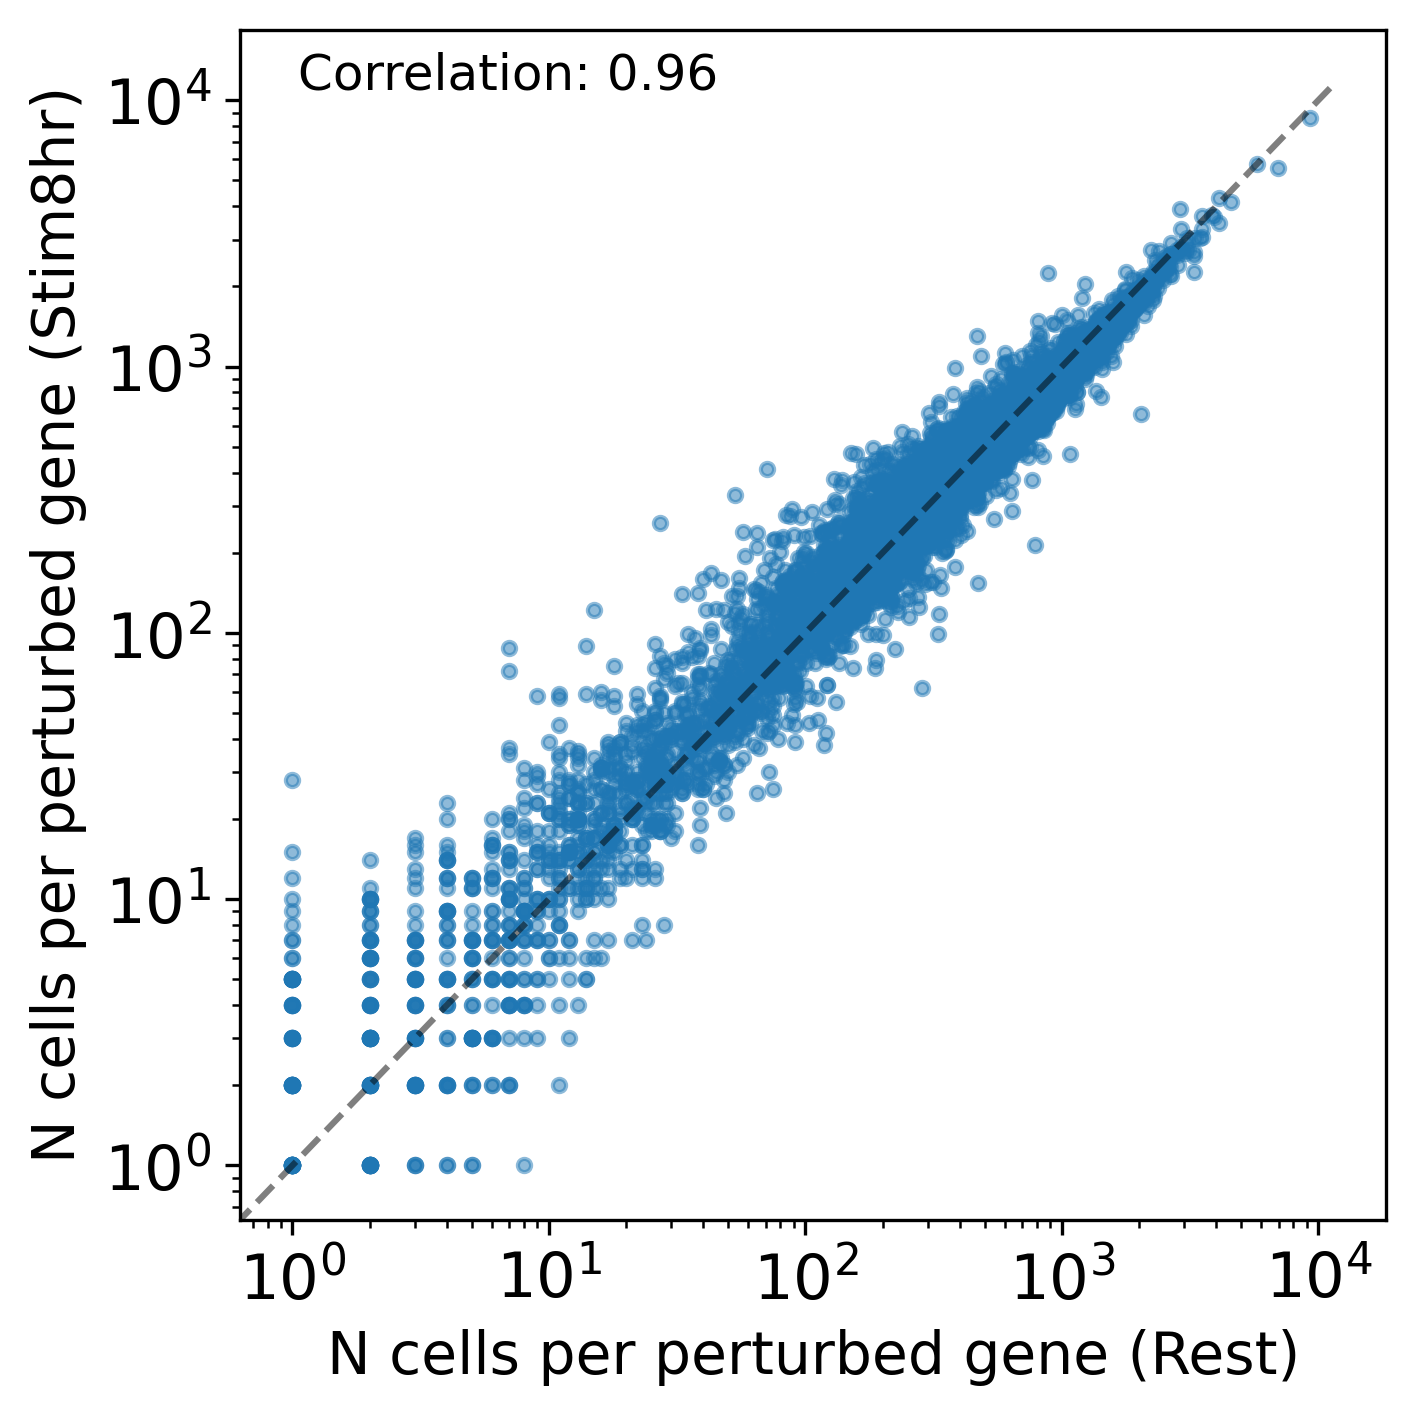

In [94]:
# Create a scatter plot comparing cell counts between conditions
plt.figure(figsize=(5, 5))
plt.scatter(all_genes_df[all_genes_df['culture_condition'] == 'Rest']['n_cells'],
           all_genes_df[all_genes_df['culture_condition'] == 'Stim8hr']['n_cells'],
           alpha=0.5, s=10)

# Add diagonal line
max_val = max(all_genes_df['n_cells'].max(), all_genes_df['n_cells'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)

plt.xlabel('N cells per perturbed gene (Rest)', fontsize=14)
plt.ylabel('N cells per perturbed gene (Stim8hr)', fontsize=14)

# Add correlation coefficient
corr = all_genes_df.pivot(columns='culture_condition', 
                         index='perturbed_gene_name', 
                         values='n_cells').corr().iloc[0,1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()